# Data Acquisition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk 
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)
nltk.download('punkt', quiet = True)
nltk.download('words', quiet = True)

True

In [3]:
import pandas as pd
import numpy as np
import wrds
import glob
from tqdm.notebook import tqdm
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from waybackpy import WaybackMachineCDXServerAPI

In [4]:
#import functions from functions.py
from function_definitions import *

In [62]:
#connect to WRDS
db = wrds.Connection(wrds_username = 'danielceleny')
#db.create_pgpass_file()

Loading library list...
Done


## Get a list of all usable stock names

In [108]:
#import table about all available data series on wrds
stocknames = db.get_table(library='crsp', table = 'stocknames')
#change dates to datetime objects
stocknames.end_date = pd.to_datetime(stocknames.end_date)
stocknames.st_date = pd.to_datetime(stocknames.st_date)
#keep only their most recent ticker and Name
stocknames = stocknames[stocknames.nameenddt == stocknames.end_date]
stocknames = stocknames[['ticker','comnam','permco','st_date','end_date']]
#get rid of duplicate ticker and permco stocks
stocknames = stocknames[stocknames.ticker.notnull()]
stocknames.sort_values('end_date', ascending = False, inplace = True)
to_drop = []
#keep the observation that has the most recent observation
#if there are several, keep one one with the oldest observation
duplicated_tickers = stocknames[stocknames.duplicated(subset = 'ticker')].ticker.unique()
for ticker in duplicated_tickers:
    sn = stocknames[stocknames.ticker == ticker]
    sn = sn[sn.end_date == sn.end_date.max()]
    #if several have recent observations keep the one with the furthest start date
    if len(sn) > 1:
        sn = sn[sn.st_date == sn.st_date.min()]
    to_keep = sn.index.values[0]
    indexes = stocknames[stocknames.ticker == ticker].index.values
    to_drop.append(indexes[~np.isin(indexes, to_keep)])
duplicated_permcos = stocknames[stocknames.duplicated(subset = 'permco')].permco.values
for permco in duplicated_permcos:
    sn = stocknames[stocknames.permco == permco]
    sn = sn[sn.end_date == sn.end_date.max()]
    if len(sn) > 1:
        sn = sn[sn.st_date == sn.st_date.min()]
    to_keep = sn.index.values[0]
    indexes = stocknames[stocknames.permco == permco].index.values
    to_drop.append(indexes[~np.isin(indexes, to_keep)])

to_drop = np.concatenate(to_drop).ravel()
stocknames = stocknames.drop(labels = to_drop)
stocknames.reset_index(inplace = True, drop = True)

print("Number of available time series: ", len(stocknames))
stocknames.head()

Number of available time series:  23688


,ticker,comnam,permco,st_date,end_date
0,TSLA,TESLA INC,53453.0,2010-06-29,2022-12-30
1,ZH,ZHIHU INC,58050.0,2021-03-26,2022-12-30
2,QFTA,QUANTUM FINTECH ACQ CORP,57870.0,2021-03-10,2022-12-30
3,STRC,SARCOS TECH & ROBOTICS CORP,57692.0,2021-03-08,2022-12-30
4,SEMR,SEMRUSH HOLDINGS INC,58043.0,2021-03-25,2022-12-30


## Find the CIK for all stocks

In [109]:
#read in the txt file linking tickers to CIKs
CIK = pd.read_csv('../data/ticker_to_CIK.txt', delimiter = "\t", header = None, names = ['ticker', 'CIK'], na_filter = False)
CIK.ticker = CIK.ticker.str.upper()
CIK

,ticker,CIK
0,AAPL,320193
1,MSFT,789019
2,BRK-B,1067983
3,UNH,731766
4,JNJ,200406
...,...,...
12079,HCICU,1829455
12080,HCICW,1829455
12081,HAWLM,46207
12082,HBANM,49196


In [110]:
#stocknames = stocknames.set_index('ticker')
stocknames = stocknames.merge(CIK, on = 'ticker', how = 'left')
#save stocknames as a gzipped csv
stocknames.to_csv("../data/stocknames.csv.gz", index = False)

print("Number of time series with an identified CIK: ", len(stocknames[~stocknames.CIK.isnull()]))
stocknames.head()

Number of time series with an identified CIK:  7077


,ticker,comnam,permco,st_date,end_date,CIK
0,TSLA,TESLA INC,53453.0,2010-06-29,2022-12-30,1318605.0
1,ZH,ZHIHU INC,58050.0,2021-03-26,2022-12-30,1835724.0
2,QFTA,QUANTUM FINTECH ACQ CORP,57870.0,2021-03-10,2022-12-30,1830795.0
3,STRC,SARCOS TECH & ROBOTICS CORP,57692.0,2021-03-08,2022-12-30,1826681.0
4,SEMR,SEMRUSH HOLDINGS INC,58043.0,2021-03-25,2022-12-30,1831840.0


## Download all 10-k urls from the SEC

In [17]:
#save the urls to all 10-K fillings
years = np.arange(2007,2023) # 2007 to 2022
#year represents the calendar year during which the statement was filed
for year in tqdm(years, leave = False):
    get_idx_files(year, "../data/SEC_idx_files/", "10-K")
    
print('Done')

Done


## Find the urls of the 10-K disclosures for all stocks

In [6]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.end_date = pd.to_datetime(stocknames.end_date)
stocknames.st_date = pd.to_datetime(stocknames.st_date)
stocknames.CIK = pd.to_numeric(stocknames.CIK, errors = 'coerce')
#paths to the previously saved 10-K files
files_10k = np.sort(glob.glob("../data/SEC_idx_files/10-K/*"))

In [112]:
#find the url of the 10-K statement corresponding to each ticker in the dataset
years = np.arange(2007,2023) # 2007 to 2022
for file, year in zip(files_10k, years):
    with open(file, "r") as f:
        tenKs = f.read()
    
    lines = tenKs.split('\n')
    allpromises = []
    
    for line in lines[:-1]:
        allpromises.append(get_url(line))
    
    with TqdmCallback(desc = 'Finding urls for {}'.format(year), leave = False):
        temp = dask.compute(allpromises)
    
    #merge the resulting dictionnaries into one
    temp = {key: val for dict_ in temp[0] for key, val in dict_.items()}
    temp_df = pd.DataFrame(temp).T.reset_index()
    temp_df.columns = ['CIK', 'url_{}'.format(year), 'filling_date_{}'.format(year), 'comnam']
    temp_df.CIK = temp_df.CIK.astype(int)
    #merge the urls and filling dates onto the stocknames dataframe
    #merge on CIK when CIK is available
    stocknames = stocknames.merge(temp_df[['CIK', 'url_{}'.format(year), 'filling_date_{}'.format(year)]],
                                  on = 'CIK', how = 'left')
    #merge on company name when CIK is not available
    stocknames = stocknames.merge(temp_df[~np.isin(temp_df.CIK,stocknames.CIK)],
                                          on = 'comnam', how = 'left')
    stocknames['CIK']= stocknames.CIK_x.combine_first(stocknames.CIK_y)
    stocknames['url_{}'.format(year)] = stocknames['url_{}_x'.format(year)].combine_first(stocknames['url_{}_y'.format(year)])
    stocknames['filling_date_{}'.format(year)] = stocknames['filling_date_{}_x'.format(year)].combine_first(stocknames['filling_date_{}_y'.format(year)])
    stocknames.drop(columns = ['CIK_x', 'CIK_y','filling_date_{}_x'.format(year),'url_{}_y'.format(year),
                               'filling_date_{}_y'.format(year),'url_{}_x'.format(year)], inplace = True)
    
print('Done')

Finding urls for 2007:   0%|          | 0/42870 [00:00<?, ?it/s]

Finding urls for 2008:   0%|          | 0/43730 [00:00<?, ?it/s]

Finding urls for 2009:   0%|          | 0/49195 [00:00<?, ?it/s]

Finding urls for 2010:   0%|          | 0/45825 [00:00<?, ?it/s]

Finding urls for 2011:   0%|          | 0/44200 [00:00<?, ?it/s]

Finding urls for 2012:   0%|          | 0/41965 [00:00<?, ?it/s]

Finding urls for 2013:   0%|          | 0/40525 [00:00<?, ?it/s]

Finding urls for 2014:   0%|          | 0/40420 [00:00<?, ?it/s]

Finding urls for 2015:   0%|          | 0/39925 [00:00<?, ?it/s]

Finding urls for 2016:   0%|          | 0/37945 [00:00<?, ?it/s]

Finding urls for 2017:   0%|          | 0/36240 [00:00<?, ?it/s]

Finding urls for 2018:   0%|          | 0/35460 [00:00<?, ?it/s]

Finding urls for 2019:   0%|          | 0/34615 [00:00<?, ?it/s]

Finding urls for 2020:   0%|          | 0/33845 [00:00<?, ?it/s]

Finding urls for 2021:   0%|          | 0/35905 [00:00<?, ?it/s]

Finding urls for 2022:   0%|          | 0/38960 [00:00<?, ?it/s]

Done


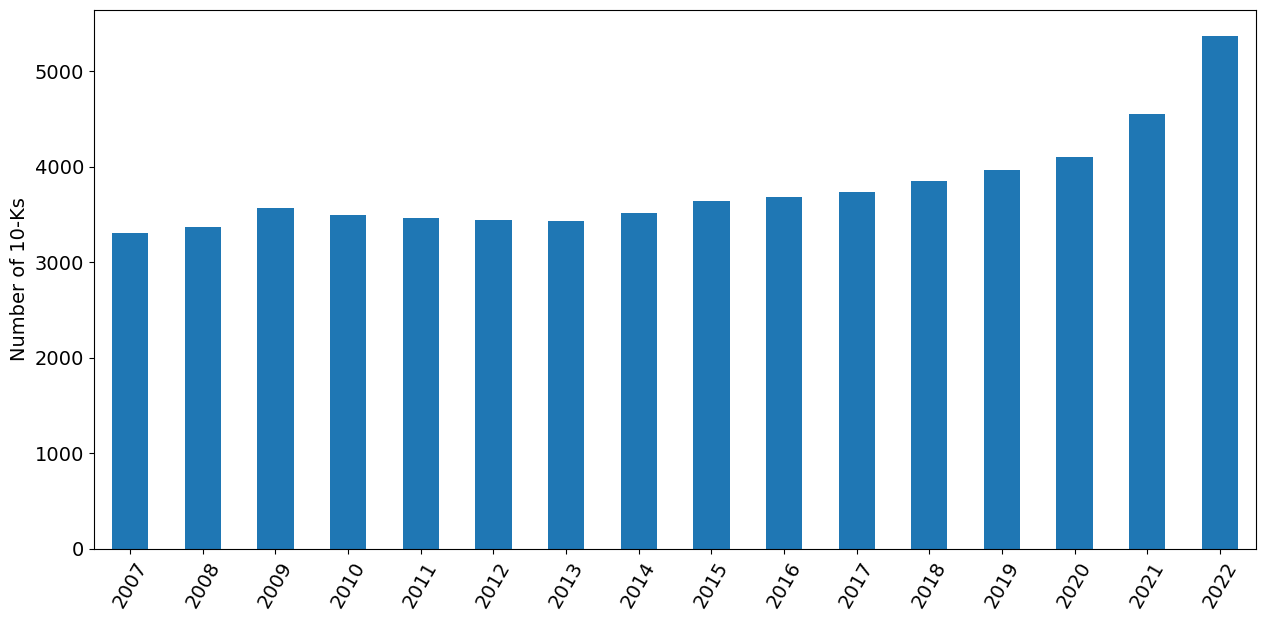

Number of firms with at least one observation: 7059
Number of firm-year observations: 60470
Average number of filings per firm: 8.566


In [7]:
#plot number of available 10-Ks
years = np.arange(2007,2023)
stocknames = stocknames[np.sort(stocknames.columns)]
nb_obs_per_year = (~stocknames.filter(like = 'url').replace('', np.nan).isnull()).sum(0)
nb_obs_per_year.plot.bar(figsize = (15,7))
plt.xticks(np.arange(16),years, rotation = 60)
#plt.title('Number of available 10-Ks per year')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Number of 10-Ks', fontsize = 14)
plt.show()
nb_obs_per_firm = (~stocknames.filter(like = 'url').isnull()).sum(1)
print(f'Number of firms with at least one observation: {(nb_obs_per_firm>0).sum()}')
print(f'Number of firm-year observations: {nb_obs_per_year.sum()}')
print(f'Average number of filings per firm: \
{round((~stocknames.filter(like = "url").replace("", np.nan).isnull()).sum(1).mean(),3)}')

In [114]:
#drop firms with no obserations
idx = stocknames.filter(like = 'url').dropna(how = 'all').index
stocknames = stocknames.loc[idx,:]
#save stocknames as a gzipped csv
stocknames.to_csv("../data/stocknames.csv.gz", index = False)

## Read in cybersecurity tactic descriptions from MITRE ATT&CK

In [348]:
#download all the tactics and techniques descritions from the website
urls = {}
urls['tactics_Reconnaissance'] = 'https://attack.mitre.org/tactics/TA0043/'
urls['tactics_Resource_Development'] = 'https://attack.mitre.org/tactics/TA0042/'
urls['tactics_Initial_Access'] = 'https://attack.mitre.org/tactics/TA0001/'
urls['tactics_Execution'] = 'https://attack.mitre.org/tactics/TA0002/'
urls['tactics_Persistence'] = 'https://attack.mitre.org/tactics/TA0003/'
urls['tactics_Privilege_Escalation'] = 'https://attack.mitre.org/tactics/TA0004/'
urls['tactics_Defense_Evasion'] = 'https://attack.mitre.org/tactics/TA0005/'
urls['tactics_Credential_Access'] = 'https://attack.mitre.org/tactics/TA0006/'
urls['tactics_Discovery'] = 'https://attack.mitre.org/tactics/TA0007/'
urls['tactics_Lateral_Movement'] = 'https://attack.mitre.org/tactics/TA0008/'
urls['tactics_Collection'] = 'https://attack.mitre.org/tactics/TA0009/'
urls['tactics_Command_and_Control'] = 'https://attack.mitre.org/tactics/TA0011/'
urls['tactics_Exfiltration'] = 'https://attack.mitre.org/tactics/TA0010/'
urls['tactics_Impact'] = 'https://attack.mitre.org/tactics/TA0040/'

for name, url in urls.items():
    df = read_cyber_description(url)
    df.to_csv(f'../data/MITRE_ATT&CK/descriptions/{name}.csv')

In [352]:
pd.read_csv('../data/MITRE_ATT&CK/descriptions/tactics_Persistence.csv', index_col = [0,1]).head(10)

Description
technique                         sub_technique                                                                           
Account Manipulation              Account Manipulation                   Adversaries may manipulate accounts to maintai...
                                  Additional Cloud Credentials           Adversaries may add adversary-controlled crede...
                                  Additional Email Delegate Permissions  Adversaries may grant additional permission le...
                                  Additional Cloud Roles                 An adversary may add additional roles or permi...
                                  SSH Authorized Keys                    Adversaries may modify the SSH authorized_keys...
                                  Device Registration                    Adversaries may register a device to an advers...
BITS Jobs                         BITS Jobs                              Adversaries may abuse BITS jobs to persistentl...
Boot or Logon Autostart Execution Boot or Logon Autostart Execution      Adversaries may configure system settings to a...
                                  Registry Run Keys / Startup Folder     Adversaries may achieve persistence by adding ...
                                  Authentication Package                 Adversaries may abuse authentication packages ...

### Read in cybersecurity descriptions from the oldest version of the website on the wayback machine

In [353]:
tactics = ['Persistence', 'Privilege_Escalation', 'Defense_Evasion', 'Credential_Access',
           'Discovery', 'Lateral_Movement', 'Execution', 'Collection', 'Exfiltration', 'Command_and_Control']
for tactic in tactics:
    user_agent = "my new app's user agent"
    oldest = WaybackMachineCDXServerAPI('attack.mitre.org', user_agent).oldest()
    url = oldest.archive_url
    response = requests.get(url+'wiki/'+tactic)
    text = response.text
    technique_pattern = re.compile('[^>]+<\/a><\/td><td class="Tactics smwtype_wpg">')
    sub_technique_pattern = re.compile('[^\d]\.\d+')
    techniques = [start_pattern.start() for start_pattern in technique_pattern.finditer(text)]
    temp = {}
    for i in range(len(techniques)):
        try:
            name, desc = re.split('<.+txt">(?=[^<])',text[techniques[i]:techniques[i+1]])
            desc = BeautifulSoup(desc, 'lxml').get_text()
        except:
            name, desc = re.split('<.+txt">(?=[^<])',text[techniques[i]:])
            desc = BeautifulSoup(desc, 'lxml').get_text()
            desc = desc.split('\n\n')[0]
        temp[name] = desc
    temp = pd.DataFrame(temp, index = ['Description']).T
    temp.index.name = 'technique'
    temp.to_csv(f'../data/MITRE_ATT&CK/old_descriptions/tactics_{tactic}.csv')
print(f"Date of the snapshot: {oldest.datetime_timestamp}")

Date of the snapshot: 2015-07-16 02:54:09


In [357]:
pd.read_csv('../data/MITRE_ATT&CK/old_descriptions/tactics_Persistence.csv', index_col = [0]).head(10)

,Description
technique,
Accessibility Features,Windows contains accessibility features that m...
AppInit DLLs,DLLs that are specified in the AppInit_DLLs va...
Basic Input/Output System,"The BIOS (Basic Input/Output System), which un..."
Bootkit,A bootkit is a malware variant that modifies t...
Change Default File Association,"When a file is opened, the default program use..."
Component Firmware,Some adversaries may employ sophisticated mean...
Component Object Model Hijacking,The Microsoft Component Object Model (COM) is ...
DLL Search Order Hijacking,Windows systems use a common method to look fo...
File System Permissions Weakness,Processes may automatically execute specific b...


## Get stock returns

In [60]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [63]:
#get monthly stock returns for all firms using wrds and crsp
returns = []
market_caps = []
industry_codes = []
for i in tqdm(range(len(stocknames)),desc = 'Getting monthly returns for all firms', leave = False):
    ret = get_returns(stocknames.permco[i],db, stocknames.st_date[i], stocknames.end_date[i],stocknames.ticker[i])
    returns.append(ret[0])
    industry_codes.append(ret[1])
    market_caps.append(ret[2])

Getting monthly returns for all firms:   0%|          | 0/7059 [00:00<?, ?it/s]

In [28]:
returns_df = pd.concat(returns, axis = 1).sort_index()
returns_df = returns_df[returns_df.index.year > 2006]
returns_df.tail()

,TSLA,QFTA,STRC,SEMR,TLGA,AGAC,DNZ,FATH,BLUA,PRPC,...,FLYD,BCRD,MSPC,MSTC,HRST,GWIN,CLCN,BRVO,BRER,ATDS
date,,,,,,,,,,,,,,,,,,,,,
2022-08,-0.072489,-0.002530,-0.020896,0.009046,-0.003039,0.003049,0.000000,-0.112150,-0.001013,-0.001010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,-0.037589,0.000507,-0.323171,-0.086390,0.002032,0.003039,0.001014,-0.465789,0.005578,0.004044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,-0.142168,0.006085,-0.090090,0.090990,0.009128,0.006061,0.013171,0.251232,0.004539,0.007049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11,-0.144326,0.000504,-0.423267,-0.224857,0.012060,0.003514,0.003500,-0.043307,0.004016,0.006000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12,-0.367334,0.012594,-0.518197,-0.141350,0.010924,0.005503,-0.003488,-0.456790,0.009000,0.003976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
market_caps_df = pd.concat(market_caps, axis = 1).sort_index()
market_caps_df = market_caps_df[market_caps_df.index.year > 2006]
market_caps_df.tail()

,TSLA,QFTA,STRC,SEMR,TLGA,AGAC,DNZ,FATH,BLUA,PRPC,...,FLYD,BCRD,MSPC,MSTC,HRST,GWIN,CLCN,BRVO,BRER,ATDS
date,,,,,,,,,,,,,,,,,,,,,
2022-08,8.636156e+11,2.479124e+08,5.077440e+08,5.315732e+08,3.936000e+08,4.086180e+08,2.834750e+08,2.340686e+08,2.594067e+08,3.980725e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,8.376595e+11,2.480382e+08,3.432986e+08,4.856508e+08,3.944000e+08,4.098600e+08,2.837625e+08,1.250419e+08,2.608537e+08,3.996825e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,7.185149e+11,2.495475e+08,3.124940e+08,5.298403e+08,3.980000e+08,4.123440e+08,2.875000e+08,1.564564e+08,2.620376e+08,4.025000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11,6.148143e+11,2.496733e+08,1.802255e+08,4.136977e+08,4.028000e+08,4.137930e+08,2.885062e+08,1.592379e+08,2.630900e+08,4.049150e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12,3.889719e+11,2.528178e+08,8.683311e+07,3.552215e+08,4.072000e+08,4.160700e+08,2.875000e+08,8.649960e+07,2.654578e+08,4.065250e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
industry_codes_df = pd.concat(industry_codes, axis = 1).sort_index()
industry_codes_df = industry_codes_df.mask(industry_codes_df.isnull()).ffill().iloc[[-1]].T
industry_codes_df.columns = ['Industry_code']
#industry_codes_df.fillna(9999, inplace = True)
industry_codes_df.index.rename('ticker', inplace = True)
industry_codes_df#.astype(int)

,Industry_code
ticker,
TSLA,9999.0
QFTA,6799.0
STRC,6799.0
SEMR,7372.0
TLGA,6799.0
...,...
GWIN,3823.0
CLCN,1311.0
BRVO,2258.0


In [65]:
#match SIC industry codes to Fama French Industry codes
SIC_to_FF = pd.read_excel('../data/SIC_to_FF_industry.xlsx', skiprows = 3).dropna(axis = 1, how = 'all')
industry_codes_df['FF_Industry_code'] = industry_codes_df.Industry_code.apply(lambda x: match_FF_industry(x,SIC_to_FF))
industry_codes_df.head()

,Industry_code,FF_Industry_code
ticker,,
TSLA,9999.0,12.0
QFTA,6799.0,11.0
STRC,6799.0,11.0
SEMR,7372.0,6.0
TLGA,6799.0,11.0


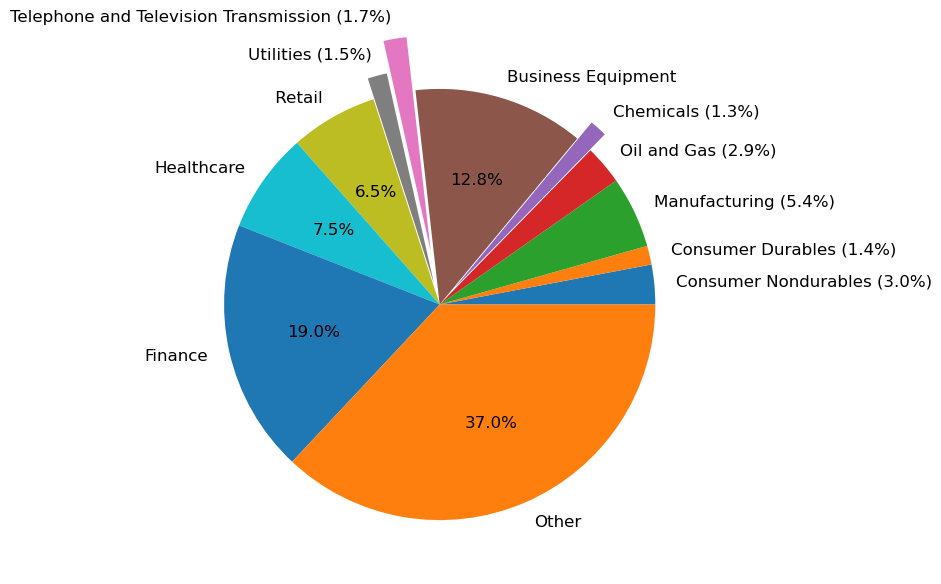

In [146]:
try:
    industries_dist = industry_codes_df.filter(like = 'FF').value_counts().sort_index()
except:
    industries_dist = stocknames[['FF_Industry_code']].value_counts().sort_index()
industries_dist.index = ['Consumer Nondurables', 'Consumer Durables',
                         'Manufacturing', 'Oil and Gas',
                         'Chemicals', 'Business Equipment',
                         'Telephone and Television Transmission',
                         'Utilities', ' Retail', 'Healthcare',
                         'Finance', 'Other']
#industries_dist.plot.pie(figsize=(5, 5), explode = (0,0,0,0,0.1,0,0.2,0.1,0,0,0,0), fontsize = 13)
plt.figure(figsize = (7,7))
plt.rcParams['font.size'] = 12
wedges, texts,autotexts = plt.pie(industries_dist, explode = (0,0,0,0,0.1,0,0.25,0.1,0,0,0,0),
                                  labels = industries_dist.index, autopct = '')
# Calculate the percentages
percentages = industries_dist / industries_dist.sum() * 100
for i, (wedge, percentage, autotext, text) in enumerate(zip(wedges, percentages, autotexts, texts)):
    if percentage >= 6:
        autotext.set_text(f'{percentage:.1f}%')
    else:
        text.set_text(text.get_text()+f' ({percentage:.1f}%)')
plt.ylabel('')
plt.show()

In [45]:
#merge the industry classifications onto stocknames
stocknames = stocknames.merge(industry_codes_df.reset_index(), on = 'ticker')
stocknames = stocknames[np.sort(stocknames.columns)]

In [49]:
#########################download yearly book values for all companies
book_value = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'ceq', 'gvkey'])
book_value.columns = ['date', 'ticker','BV', 'gvkey']
book_value = book_value[book_value.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])

temp = book_value[['ticker', 'gvkey']]
temp = temp.groupby('ticker').last()
book_value.drop(columns = ['gvkey'], inplace = True)
#stocknames = stocknames.merge(temp, on = 'ticker', how = 'left')

book_value.dropna(how = 'any', inplace = True)
book_value.date = pd.to_datetime(book_value.date)
book_value = book_value.pivot(index = 'date', columns = 'ticker', values = 'BV')
#Winsorize by year
book_value = book_value.groupby(book_value.index.year).apply(lambda x: 
                                x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())

book_value = book_value.ffill()
book_value.index = book_value.index.to_period('M')
book_value = book_value.multiply(1000000) #in millions on wrds
temp_book_value = book_value[book_value.index.year < 2023]
book_value = book_value[(book_value.index.year > 2006) & (book_value.index.year < 2023)]
book_value[book_value<0] = np.nan
book_value.dropna(how = 'all', axis = 1, inplace = True)

#########################book to market ratio
book_to_market = book_value.div(market_caps_df)

#########################firm age
firm_age = temp_book_value.dropna(axis = 1, how = 'all').copy()
first_date = temp_book_value.apply(pd.Series.first_valid_index)
last_date = temp_book_value.apply(pd.Series.last_valid_index)
for ticker in firm_age.columns:
    ages = np.arange(1,len(firm_age.loc[first_date[ticker]:last_date[ticker],ticker])+1)
    firm_age.loc[first_date[ticker]:last_date[ticker],ticker] = ages/12
    
#########################compute yearly Return on assets (ROA) for all companies
#ROA = operating income before depreciation / Total assets
net_income = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'ni'])
net_income.columns = ['date', 'ticker','net_income']
net_income = net_income[net_income.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
net_income.dropna(how = 'any', inplace = True)
net_income.date = pd.to_datetime(net_income.date)
net_income = net_income.pivot(index = 'date', columns = 'ticker', values = 'net_income')
net_income.index = net_income.index.to_period('M')
net_income = net_income[(net_income.index.year > 2006) & (net_income.index.year < 2023)]
#Winsorize by year
net_income = net_income.groupby(net_income.index.year).apply(lambda x: 
                                x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())
net_income = net_income.ffill()

total_assets = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'at'])
total_assets.columns = ['date', 'ticker','total_assets']
total_assets = total_assets[total_assets.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
total_assets.dropna(how = 'any', inplace = True)
total_assets.date = pd.to_datetime(total_assets.date)
total_assets = total_assets.pivot(index = 'date', columns = 'ticker', values = 'total_assets')
total_assets.index = total_assets.index.to_period('M')
total_assets = total_assets.replace(0, np.nan)
total_assets = total_assets[(total_assets.index.year > 2006) & (total_assets.index.year < 2023)]
#Winsorize by year
total_assets = total_assets.groupby(total_assets.index.year).apply(lambda x: 
                                    x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())
total_assets = total_assets.ffill()

ROA = net_income.div(total_assets)
ROA = ROA.groupby(ROA.index.year).apply(lambda x: 
                  x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())

#########################Intangible assets
intangibles = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'intan'])
intangibles.columns = ['date','ticker','intangibles']
intangibles = intangibles[intangibles.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
intangibles.dropna(how = 'any', inplace = True)
intangibles.date = pd.to_datetime(intangibles.date)
intangibles = intangibles.pivot(index = 'date', columns = 'ticker', values = 'intangibles')
intangibles.index = intangibles.index.to_period('M')
intangibles = intangibles[(intangibles.index.year > 2006) & (intangibles.index.year < 2023)]
#Winsorize by year
intangibles = intangibles.groupby(intangibles.index.year).apply(lambda x: 
                                  x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())
intangibles = intangibles.ffill()
intangibles_to_assets = intangibles.div(total_assets)

#########################firm size
total_assets = total_assets.multiply(1000000)

#########################Tobin's Q
liabilities = total_assets.sub(book_value)
TobinQ = liabilities.add(market_caps_df).div(total_assets)
#Winsorize by year
TobinQ = TobinQ.groupby(TobinQ.index.year).apply(lambda x: 
                        x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())

#########################Market Beta
betas = db.get_table(library = 'comp', table = 'co_mthly', columns = ['datadate', 'gvkey', 'beta'])
betas.columns = ['date', 'gvkey', 'beta']
betas.date = pd.to_datetime(betas.date)
betas = betas.pivot(index = 'date', columns = 'gvkey', values = 'beta')
betas = betas.loc[:,betas.columns.isin(stocknames.gvkey)]
betas.columns = [stocknames.loc[stocknames.gvkey == b].ticker.values[0] for b in betas.columns]
betas.index = betas.index.to_period('M')
betas = betas[(betas.index.year > 2006) & (betas.index.year < 2023)]
#Winsorize by year
betas = betas.groupby(betas.index.year).apply(lambda x: 
                      x.stack().clip(lower = x.stack().quantile(0.01), upper = x.stack().quantile(0.99)).unstack())

In [50]:
#save the monthly returns, market caps and stocknames
save_path = '../data/returns/'
#returns_df.to_csv(save_path + 'monthly_returns.csv.gz')
#market_caps_df.to_csv(save_path + 'monthly_mkt_caps.csv.gz')
#stocknames.to_csv('../data/stocknames.csv.gz',index = False)
book_value.to_csv(save_path + 'book_values.csv.gz')
total_assets.to_csv(save_path + 'firm_sizes.csv.gz')
ROA.to_csv(save_path+'ROA.csv.gz')
firm_age.to_csv(save_path+'firm_ages.csv.gz')
TobinQ.to_csv(save_path+'TobinsQ.csv.gz')
book_to_market.to_csv(save_path+'book_to_market.csv.gz')
betas.to_csv(save_path+'mkt_betas.csv.gz')
intangibles_to_assets.to_csv(save_path+'intangibles_to_assets.csv.gz')

In [125]:
# more financial ratios 

# debt_assets: debt to assets
# roe: return on equity
# ps: price to sales                                             NEM
# npm: net profit margin                                         NEM   
# pe_exi: price to earnings
# at_turn: asset turnover
# cash_ratio: cash+short-term inv to current liabilities
# gpm: gross profit margin 
# cfm: cash flow margin                                          NEM
# sale_invcap: sales per dollar of invested capital
# capital_ratio: capitalization ratio
# RD_SALE: R&D expenses as a fraction of sales
# roce: return on capital employedinvc

ratios = db.get_table(library='wrdsapps_finratio', table='firm_ratio',
                      columns = ['gvkey','public_date','debt_assets','roe', 'pe_exi', 'gpm',
                                 'at_turn', 'cash_ratio', 'sale_invcap', 'capital_ratio','RD_SALE','roce'])
#rename the columns
ratios.columns = ['gvkey','date','debt2assets','ROE','price2earnings','profit_margin','asset_turnover',
                  'cash_ratio','sales2invested_cap','capital_ratio','r&d2sales','ROCE']
#set the date
#ratios = ratios.rename(columns = {'public_date':'date'})
ratios.date = pd.to_datetime(ratios.date)
ratios.set_index('date',inplace = True)
ratios = ratios.to_period('M').reset_index()
ratios = ratios[ratios.date.dt.year > 2006]
# limit to stocks from 'stocknames'
ratios = ratios[ratios.gvkey.isin(stocknames.gvkey)]
# add the ticker
ratios = ratios.merge(stocknames[['gvkey','ticker']]).drop('gvkey', axis = 1)
# set the index to be date and ticker
ratios.set_index(['date','ticker'], inplace = True)
ratios = ratios.sort_index()

#Winsorize by year
for year in ratios.index.levels[0].year.unique():
    ratios[ratios.index.get_level_values(0).year == year] = \
                ratios[ratios.index.get_level_values(0).year == year].apply(lambda x: 
                x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
    
# save the ratios
save_path = '../data/returns/'
ratios.to_csv(save_path+'fin_ratios.csv.gz')

In [85]:
db.close()